In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Datasets
## Deliveries 
Contains: purchase id, purchase timestamp, delivery timestamp, delivery company.   
Usage: Check the typical delivery time for your company after purchase.   
Questions: Why company name is a number, is it company id? Czy firma ma monopol na dany towar czy z różnych firm możemy go uzyskać, a jeśli tak to czy dostaniemy dane jaka firma jakie produkty dostarcza? Czy czas między dostawą a złożeniem zamówienia, jest zależny od pory roku (tj czy przed świętami ten czas się wydłuża?)  
Plots: delivery timestamp - purchase timestamp od czasu w roku, i średnia w zależności od delivery_company  
Additional data: Lista produktów zamówionych w danej dostawie

# Datasets
## Deliveries 
Contains: purchase id, purchase timestamp, delivery timestamp, delivery company.   
Usage: Check the typical delivery time for your company after purchase.   
Questions: Why company name is a number, is it company id? Czy firma ma monopol na dany towar czy z różnych firm możemy go uzyskać, a jeśli tak to czy dostaniemy dane jaka firma jakie produkty dostarcza? Ja rozumiem to tak, że to jest jaką firmą kureirską będziemy wysłać produkt po tym jak zakupi go u nas użytkownik. Czy czas między dostawą a złożeniem zamówienia, jest zależny od pory roku (tj czy przed świętami ten czas się wydłuża?) - jeśli jest to nasza dostawa, to chyba nie ma sensu tego sprawdzać w naszym zadaniu
Plots: delivery timestamp - purchase timestamp od czasu w roku, i średnia w zależności od delivery_company  
Additional data: Lista produktów zamówionych w danej dostawie


Ja generalnie uważam, że ten dataset jest nam nie potrzebny w przypadku naszego zadania. Może być potrzebny do tego, aby sprawdzać po złączeniu z danymi z products kiedy zamawiane jest najwięcej produktów (do tego celu potrzebujemy jeszcze danych z okresu październik - grudzień).

In [2]:
df = pd.read_json("./../data/raw/deliveries.jsonl", lines=True)
df.set_index('purchase_id', inplace=True)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["delivery_company", 'delivery_timestamp'])
df['purchase_timestamp'] = pd.to_datetime(df['purchase_timestamp'])
df['delivery_timestamp'] = pd.to_datetime(df['delivery_timestamp'])
df['delivery_company'] = df["delivery_company"].astype(int)
df


,purchase_timestamp,delivery_timestamp,delivery_company
purchase_id,,,
20001,2021-01-06 22:50:03,2021-01-09 22:51:44,516
20002,2021-01-08 21:33:21,2021-01-13 21:35:21,360
20003,2021-01-07 23:48:32,2021-01-11 23:50:01,516
20004,2021-01-10 02:17:49,2021-01-15 02:20:55,360
20005,2021-01-06 08:05:00,2021-01-11 08:06:21,360
...,...,...,...
22776,2021-01-01 09:08:39,2021-01-04 09:13:34,360
22777,2021-01-03 00:04:24,2021-01-07 00:08:31,360
22778,2021-01-02 19:16:35,2021-01-04 19:20:08,360


## Products
Contains: product id, product name, category path, price   
Usage:   możemy sprawdzać jakie kategorie produktów są najpopularniejsze - i w jakim czasie (łącząc ten dataset z deliveries) oraz do jakiej ceny. 
Questions: Why some prices are negative? What does it mean? Czy potrzebujemy category path? Przewidujemy potrzebe zakupu konkretnej rzeczy co kategoryzujemy?
Data changes: przerobić kolumne category_path, join products z sessions i sprawdzić popularność po kategoriach, oraz częstość zakupów  
Plots: join z sessions
Additional data:

In [3]:
df = pd.read_json("./../data/raw/products.jsonl", lines=True)
df.set_index('product_id', inplace=True)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["price"])
df = df[df.price >= 0]
df

,product_name,category_path,price
product_id,,,
1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,5.897000e+01
1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2.048500e+03
1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,4.999000e+01
1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,4.999000e+01
1006,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,5.990000e+01
...,...,...,...
1315,Jabra Talk,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,5.499000e+01
1316,Plantronics Voyager Legend,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,2.490000e+02
1317,Plantronics Savi W740,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,1.303960e+09


## Sessions
Contains: session_id, timestamp, user_id, product_id, event_type, offered_discount, purchase_id  
Usage: jakie produkty mają największe wzięcie, też jak często są wyświetlane   
Questions: Jak zniżka wpływa na szybkie zniknięcie towaru z magazynu? Jeśli jest planowana, to ile więcej należy kupić rzeczy z danej kategorii? 

In [4]:
pd.read_json("./../data/raw/sessions.jsonl", lines=True)

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2021-01-10 16:32:24,102.0,1075.0,VIEW_PRODUCT,5,NaN
1,100001,2021-01-10 16:33:16,102.0,1079.0,VIEW_PRODUCT,5,NaN
2,100001,2021-01-10 16:37:18,102.0,1078.0,VIEW_PRODUCT,5,NaN
3,100001,2021-01-10 16:38:07,102.0,1077.0,VIEW_PRODUCT,5,NaN
4,100002,2021-01-06 22:28:51,102.0,1007.0,VIEW_PRODUCT,5,NaN
...,...,...,...,...,...,...,...
156858,109153,2021-01-01 05:27:44,299.0,1017.0,VIEW_PRODUCT,20,NaN
156859,109153,2021-01-01 05:31:55,299.0,1070.0,VIEW_PRODUCT,20,NaN
156860,109153,2021-01-01 05:32:32,299.0,1034.0,VIEW_PRODUCT,20,NaN
156861,109153,2021-01-01 05:36:26,299.0,1036.0,VIEW_PRODUCT,20,NaN


## Users
Contains: user_id, name, city, street

Usage: możemy spróbować znaleźć zależność jacy użytkownicy (skąd pochodzący) jakie produkty kupują, dzięki temu w zależności od aktywnych użytkowników w ostatnim czasie i ich miejsca zamieszkania możemy stwierdzić czego prawdopodobnie będą potrzebować.

Questions: brak

In [5]:
pd.read_json("./../data/raw/users.jsonl", lines=True)

,user_id,name,city,street
0,102,Borys Klatka,Szczecin,plac Kolorowa 28/81
1,103,Adrian Zdancewicz,Poznań,ulica Jagiellońska 09
2,104,Albert Choina,Gdynia,ulica Jaworowa 11
3,105,Dagmara Dawidczyk,Kraków,ulica Asnyka 87/26
4,106,Stefan Łuszczyk,Warszawa,aleja Ludowa 98
...,...,...,...,...
195,297,Angelika Szoka,Radom,al. Sokola 282
196,298,Witold Sidorczuk,Wrocław,pl. Zacisze 62/54
197,299,Nicole Kryszczuk,Szczecin,aleja Żwirki i Wigury 63/58
198,300,Julita Białach,Kraków,ul. Rataja 866


## Wykresy danych

###  Ilość zamówień w danym miesiącu

In [34]:
df = pd.read_json("./../data/raw/deliveries.jsonl", lines=True)
df.set_index('purchase_id', inplace=True)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["delivery_company", 'delivery_timestamp'])
df['purchase_timestamp'] = pd.to_datetime(df['purchase_timestamp'])
df['delivery_timestamp'] = pd.to_datetime(df['delivery_timestamp'])
df['delivery_company'] = df["delivery_company"].astype(int)
df

,purchase_timestamp,delivery_timestamp,delivery_company
purchase_id,,,
20001,2021-01-06 22:50:03,2021-01-09 22:51:44,516
20002,2021-01-08 21:33:21,2021-01-13 21:35:21,360
20003,2021-01-07 23:48:32,2021-01-11 23:50:01,516
20004,2021-01-10 02:17:49,2021-01-15 02:20:55,360
20005,2021-01-06 08:05:00,2021-01-11 08:06:21,360
...,...,...,...
22776,2021-01-01 09:08:39,2021-01-04 09:13:34,360
22777,2021-01-03 00:04:24,2021-01-07 00:08:31,360
22778,2021-01-02 19:16:35,2021-01-04 19:20:08,360


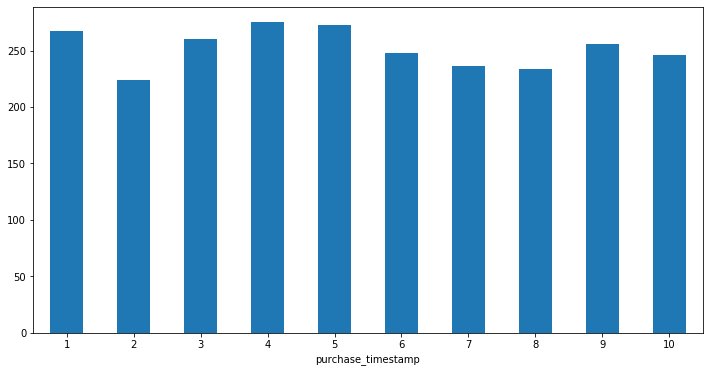

In [35]:
fig, axs = plt.subplots(figsize=(12, 6))
df.groupby(df["purchase_timestamp"].dt.month)["purchase_timestamp"].count().plot(kind='bar', rot=0, ax=axs)

In [36]:
# sprawdzenie 
df['month'] = 
sum = 0
for value in df['month'].values:
    if value == 1:
        sum += 1
print(sum)

KeyError: 'month'